# Korean vishing Detection using KoBERT model from HuggingFace on TensorFlow

## Install dependencies

Install the tensorFlow to work on GPU for WSL2 Ubuntu 20.04 LTS (Focal Fossa) on Windows 11 Pro as follows described in the [TensorFlow documentation](https://www.tensorflow.org/install/pip#windows-wsl2).
1. Install WSL2
2. Install the NVIDIA drive
3. NVIDIA’s setup docs for CUDA in WSL2
4. Install TensorFlow
5. Verify the installation
6. Install the transformers library
7. Install the pandas library
8. Install the numpy library
9. Install the scikit-learn library
10. Install the matplotlib library
11. Install the seaborn library
(optional)
12. Install the tqdm library
13. Install the sentencepiece library
14. Install the pydot library
15. Install the graphviz library

In [1]:
# Verify the installation:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Check if TensorFlow is using GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

2023-12-08 14:59:51.406552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 14:59:51.775855: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-08 14:59:53.115049: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mbmk92/anaconda3/envs/dltest/lib/
2023-12-08 14:59:53.122451: W tensorflow/compiler/xla/str

Num GPUs Available:  1
Num GPUs Available:  1
Default GPU Device: /device:GPU:0


2023-12-08 14:59:54.870377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 14:59:55.005020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 14:59:55.005065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 14:59:55.007281: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other ope

In [2]:
# !pip install transformers pandas numpy

In [3]:
# !pip install --upgrade pip

In [4]:
# !pip install tensorflow
# !pip3 install tensorflow[and-cuda]

In [5]:
# load the libraries
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification ,TFBertModel, AutoTokenizer, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
from transformers import AdamWeightDecay
import pandas as pd
import numpy as np
import re, os, time, gc, psutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from keras.utils import to_categorical
from transformers import AdamW
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.losses import SparseCategoricalCrossentropy
# from tensorflow.keras.optimizers import AdamW,
# from tensorflow.keras.losses import SparseCategoricalCrossentropy
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.utils import to_categorical

## Load the dataset and cleaning

In [6]:
# Import the dataset KorCCVi
df = pd.read_csv('KorCCVi_v2.csv')
# df = pd.read_csv('KorCCViD_v1.3_fullcleansed.csv')
df.head()

,id,transcript,confidence,label
0,0,저는 여행 다니는 것을 굉장히 좋아하는데요. 그래가지고 스페인이나 뭐 영국 유럽 아...,NaN,0
1,1,반려동물을 키우고 계신가요? 혹시 안 키우고 계시다면은 어떤 반려동물을 한번 키워보...,NaN,0
2,2,씨는 주로 어떤 음식 좋아하시나요? 저는 근데 가리는 게 거의 없어서 대부분 다 ...,NaN,0
3,3,씨는 반려동물 어~ 좋 뭐 어떤 동물 좋아하세요? 저는 고양이를 정말 좋아하는데요...,NaN,0
4,4,가장 좋아하는 음식이 무엇인가요? 저는 주로 먹는 거를 좋아해서 음식을 가리지 않고...,NaN,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927 entries, 0 to 2926
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          2927 non-null   int64  
 1   transcript  2927 non-null   object 
 2   confidence  0 non-null      float64
 3   label       2927 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 91.6+ KB


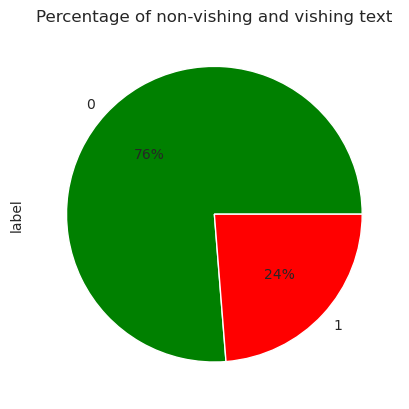

In [8]:
# visualize the dataset with pie chart 
df['label'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['green', 'red'])
plt.title('Percentage of non-vishing and vishing text')
plt.show()

In [9]:
# function to plot the class distribution
def plot_class_distribution(data, title):
    sns.set(style="whitegrid")
    # sns.set(style="ticks")
    ax = sns.countplot(x='label', data=data)
    ax.set_title(title)
    
    # Annotate the bars with the number of samples
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
        
    plt.show()

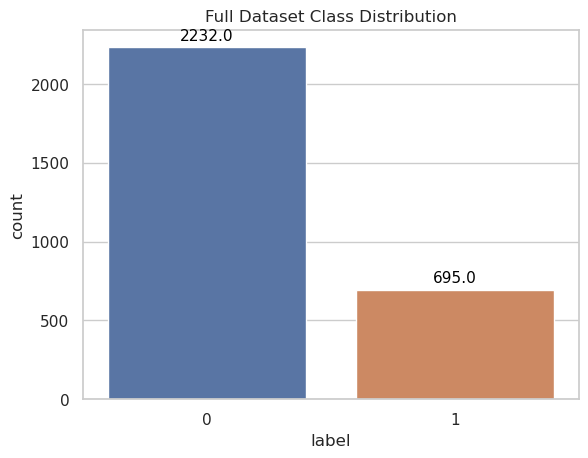

In [10]:
# drop the colum we don't need
df.drop(['confidence'], axis=1, inplace=True)
plot_class_distribution(df, 'Full Dataset Class Distribution')

In [11]:
# function to perform the cleaning parts
def apply_replacement(src_df, replace_func):
    ret_df = src_df
    ret_df['transcript'] = ret_df['transcript'].apply(lambda x: replace_func(x))
    return ret_df

In [12]:
# remove the unwanted word and characters from the dataset
def word_replace(x):
    example_word_replace_list = {'o/': '',
                                 'b/': '',
                                'n/': '',
                                '\n': ' ',
                                'name': '',
                                'laughing': '',
                                'clearing': '',
                                'singing': '',
                                'applauding': ''}

    for i in example_word_replace_list:
        x = x.replace(i, example_word_replace_list[i])
    return x

In [13]:
# remove the special character from the transcripts
def remove_special_characters(sentence):
    sentence = re.sub(r"[^a-zA-Z0-9ㄱ-ㅣ가-힣]", ' ', sentence)
    sentence = re.sub(r"[-~=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]", '', sentence)
    return sentence

In [14]:
# remove x and O from the transcripts
def remove_x_o(sentence):
    sentence = re.sub(r"[xX]", '', sentence)
    sentence = re.sub(r"[oO]", '', sentence)
    sentence = re.sub(r"(o|O|\ㅇ|0|x){2,}", '', sentence)
    return sentence

In [15]:
# remove all the digits and numbers from the transcripts
def remove_digits(sentence):
    sentence = re.sub(r"[0-9]", '', sentence)
    return sentence

In [16]:
# remove all extra spaces from the transcripts
def remove_extra_spaces(sentence):
    sentence = re.sub(r"\s+", ' ', sentence)
    return sentence

In [17]:
# Apply all the cleaning functions to the dataset
df = apply_replacement(df, word_replace)
df = apply_replacement(df, remove_special_characters)
df = apply_replacement(df, remove_x_o)
df = apply_replacement(df, remove_digits)
df = apply_replacement(df, remove_extra_spaces)

In [18]:
# print the row with any English character in the transcript
print(df[df['transcript'].str.contains('[a-zA-Z]')].head(5))

        id                                         transcript  label
69      69  네 씨는 혹시 여행 좋아하시나요 저는 되게 많이 좋아합니다 국내 해외 다 좋아하고 ...      0
1168  1168  언니 요새 이가 여자 친구한테 선물 받은 거 있어 있긴 있는 거 같더라고 그렇지 않...      0
1452  1452  나는 지금 강아지를 년째 키우고 있는 중이거든 우리 강아지 이름은 코난이고 아 얘가...      0
2233  2233  본인 성함 알겟습니다 제가 첫번째는 이제 본인이 혹시라도 이제 깡통 계좌 발생으로 ...      1
2239  2239  보니까 서면조사를 받으셔야 되고요 알겠습니다 그럼 말씀 드릴게요 계속 말씀드렸다시피...      1


In [19]:
# save the cleaned dataset
df.to_csv('KorCCVi_v2_cleaned.csv', index=False)

## Training the KoBERT model using the Tokenizer provided by KoBERT

In [20]:
# Load the cleaned dataset
df = pd.read_csv('KorCCVi_v2_cleaned.csv')

In [21]:
sentences = df['transcript'].values
labels = df['label'].values

### Tokenization & Input Formatting Method 1

In [22]:
# Load the KoBERT tokenizer
# tokenizer = BertTokenizer.from_pretrained("kykim/bert-kor-base")
# tokenizer = BertTokenizer.from_pretrained('monologg/kobert')

In [23]:
# # Tokenize the input texts
# def convert_example_to_feature(review):
#     return tokenizer.encode_plus(review, 
#                                  add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                                  max_length = None,           # 64, 512, None, max_length, Pad & truncate all sentences 
#                                  # pad_to_max_length = True,
#                                  padding='max_length',        # True, longest, max_length, Pad & truncate all sentences
#                                  return_attention_mask = True,
#                                  return_token_type_ids = False,
#                                  truncation=True)

In [24]:
# # Map to the expected input to TFBertForSequenceClassification, see https://huggingface.co/transformers/model_doc/bert.html#tfbertforsequenceclassification
# input_ids = []
# attention_masks = []

In [25]:
# for sent in sentences:
#     encoded_dict = convert_example_to_feature(sent)
#     input_ids.append(encoded_dict['input_ids'])
#     attention_masks.append(encoded_dict['attention_mask'])

In [26]:
# # # Print the shapes of the data.
# print('Original: ', sentences[0])
# print('Token IDs:', input_ids[0])

In [27]:
# # Convert the lists into tensors.
# # input_ids = tf.convert_to_tensor(input_ids)
# # attention_masks = tf.convert_to_tensor(attention_masks)
# # labels = tf.convert_to_tensor(labels)
# 
# input_ids = tf.constant(input_ids)
# attention_masks = tf.constant(attention_masks)
# labels = tf.constant(labels)

In [28]:
# input_ids

In [29]:
# labels

In [30]:
# attention_masks

In [31]:
# # split the dataset into train, validation and test set
# # train_ratio = 0.7
# # validation_ratio = 0.15
# # test_ratio = 0.15
# #     
# # train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.2)
# # train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
# # train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=42, test_size=0.2)
# # Split data into train and validation sets
# train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
# train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size=0.1)

### Split the dataset

In [32]:
# Split data into training and testing sets
# train_inputs, validation_inputs, train_inputs, validation_labels = train_test_split(sentences, labels, random_state=2018, test_size=0.2)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.2)

In [33]:
X_train

array(['예 지금 통화 가능하신가요 혹시 정보인데요 뭐 이름도 들어보지도 마시고요 제가 이거 이쪽으로 서울지방경찰청 건물 현장에서 대량이 복지신용카드 주민등록증 하고 통장 저기가 발견되어서 여보세요 예 예 예 예 지금 들리시나요 이동을 한번 아시나요 보내시고 화요일에 지난주 화요일에 제출확인서 사람 죽음으로 금융사기단 했는데요 복지신용카드 위조하는 하고요 통장을 통장 동일한 빨간색이 이렇게 전화를 예 예 가시나요 그럼 뭐 최근에 신청 좀 해 가지고 차를 가지고 있으니까 생각 중이라 시간 적어주시고요 되었습니다 등록 안 하신 건 없으시고요 맛있는 거 통신사가 어디 통신을 하지 않게 줄 수 있나요 계장님 오기 전에 예전에 뭐 분 결혼식 내가 일단은 이거 설명해 드리겠습니다 사건이 메모 여기서 뭐 뭐 국가 공무원 현직 경찰 보험사 직원들도 경찰관입니다 어 이거 예 예 가장 중요한 점은 어머니라면 경찰 총 정리 없이 그냥 뭐 하셔 통장 만들어 가지고 있거든요 피곤 하신데 없으시고요 쪽이나 뭐라고 하셔 가지고 사버린다 은행 거래내역 있으신가요 최근에 뭐 신분증이나 그러지는 없으시고요 저희가 그거 현장에서 발견한 통장이거든요 예 농협이랑 하나은행 통장 있어 통장에 농협 통장 있으신가요 괜찮아지면 제가 자주 자주 거래하시는 통장 계신가요 뭐 이거를 해 봤는데 다들 하신다고 얘랑 아닐 거고 그래서 제가 전화를 하다 보니까 어렵다 G 뭐 만 원 정도 받고 뭐 판매하시는 분들도 계시더라구요 홈 있고 월 있으시다고요 ',
       '아 안녕하세요 저희 가족은 인 가족입니다 두 살 연하의 말 안 듣는 남편과 더 개구지고 더 말 안 듣는 열한 살짜리 아들을 데리고 있는 속 썩고 사는 마흔네 살 주부 그러면서 애증의 관계로 미움과 사랑이 항상 교차하면서 잘 지내고 있는 이라고 합니다 가족이 어떻게 되시나요 어 저랑 동갑이신 거 같아요 저는두 저 년생 마흔네 살 이고요 저도 마찬가지로 아들 한 명 그리고 남편이랑 이르 살고 있는 인 가족이에요 어 아들 저희 학년 인제 열두 살이

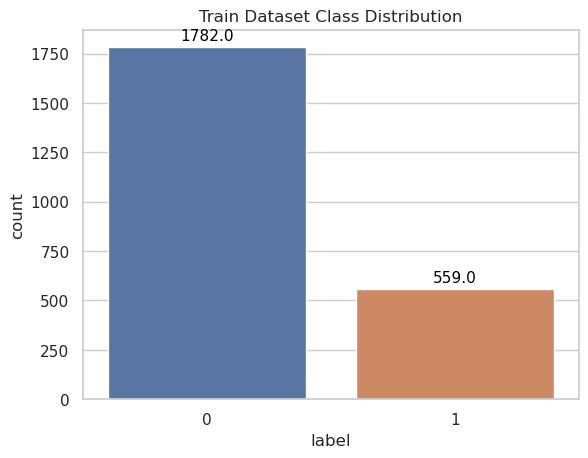

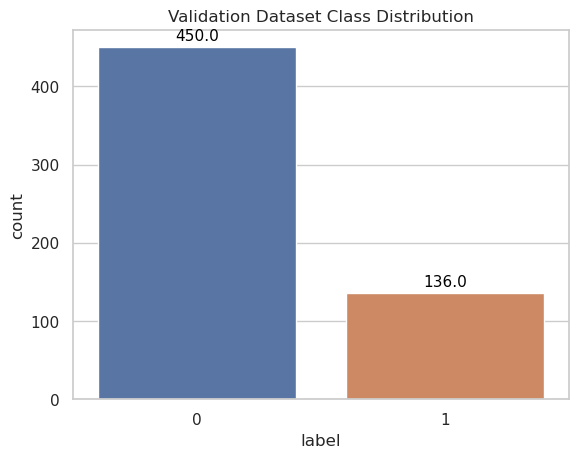

In [34]:
# plot the class distribution of train and validation set
plot_class_distribution(pd.DataFrame(y_train, columns=['label']), 'Train Dataset Class Distribution')
plot_class_distribution(pd.DataFrame(y_test, columns=['label']), 'Validation Dataset Class Distribution')

### Tokenization & Input Formatting Method 2


In [38]:
# Define hyperparameters
model_name = "monologg/kobert"
batch_size = 16 # 32, 64, 128
epochs = 1
# Lower learning rates are often better for fine-tuning transformers
learning_rate = 3e-5    #2e-5, 5e-5, 4e-5
weight_decay_rate=0.01

In [39]:
# Load KoBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

#### Tokenize dataset NEW method (BARD)

In [40]:
# Preprocess training data
X_train_list = X_train.tolist()
train_inputs = tokenizer(X_train_list, padding="max_length", truncation=True, return_tensors="tf")

2023-12-08 15:01:03.294526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 15:01:03.294638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 15:01:03.294659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 15:01:03.294838: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 15:01:03.294846: I tensorflow/core/co

In [41]:
# Convert training labels to one-hot encoding
train_labels = to_categorical(y_train)

In [42]:
# Create TF training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs["input_ids"], train_labels)).batch(batch_size)

In [43]:
# Preprocess test data
X_test_list = X_train.tolist()
test_inputs = tokenizer(X_test_list, padding="max_length", truncation=True, return_tensors="tf")

In [44]:
# Convert test labels to one-hot encoding
test_labels = to_categorical(y_test)

#### Training the KoBERT model

In [45]:
# Define optimizer, loss function, and metrics
optimizer = AdamWeightDecay(learning_rate=learning_rate)      # No loss argument!
# optimizer1 = AdamW(learning_rate=learning_rate)
optimizer2 = Adam(learning_rate)  # No loss argument!

loss_fn = SparseCategoricalCrossentropy(from_logits=True)

metrics = tf.keras.metrics.SparseCategoricalAccuracy()

In [46]:
# from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
# early_stopping = EarlyStopping(monitor="val_loss", patience=3)
# model_checkpoint = ModelCheckpoint("best_model.hdf5", monitor="val_accuracy", save_best_only=True)

In [47]:
# Load pretrained KoBERT model
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2, from_pt=True)

2023-12-08 15:01:10.011640: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
# Fine-tune the model
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [49]:
# get the model details
# get_model_details(model)

In [50]:
# get the model settings and parameters
# get_model_settings(model)

In [51]:
# Train the model
history = model.fit(train_dataset, epochs=epochs, validation_data=(test_inputs["input_ids"], test_labels))

# history = model.fit(train_dataset, epochs=epochs, validation_data=(test_inputs["input_ids"], test_labels))
# history = model.fit(train_dataset)

2023-12-08 15:01:32.429786: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 96.00MiB (rounded to 100663296)requested by op tf_bert_for_sequence_classification/bert/encoder/layer_._3/intermediate/Gelu/mul_1
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-12-08 15:01:32.429891: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2023-12-08 15:01:32.429905: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 97, Chunks in use: 95. 24.2KiB allocated for chunks. 23.8KiB in use in bin. 677B client-requested in use in bin.
2023-12-08 15:01:32.429911: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin

ResourceExhaustedError: Graph execution error:

Detected at node 'tf_bert_for_sequence_classification/bert/encoder/layer_._3/intermediate/Gelu/mul_1' defined at (most recent call last):
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_4707/1191927106.py", line 2, in <module>
      history = model.fit(train_dataset, epochs=epochs, validation_data=(test_inputs["input_ids"], test_labels))
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1534, in train_step
      y_pred = self(x, training=True)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1639, in run_call_with_unpacked_inputs
      y_pred = self(x, return_loss=True, training=False)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 1651, in call
      outputs = self.bert(
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1639, in run_call_with_unpacked_inputs
      y_pred = self(x, return_loss=True, training=False)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 870, in call
      encoder_outputs = self.encoder(
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 556, in call
      for i, layer_module in enumerate(self.layer):
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 562, in call
      layer_outputs = layer_module(
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 518, in call
      intermediate_output = self.intermediate(hidden_states=attention_output)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 422, in call
      hidden_states = self.intermediate_act_fn(hidden_states)
    File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/keras/activations.py", line 359, in gelu
      return tf.nn.gelu(x, approximate)
Node: 'tf_bert_for_sequence_classification/bert/encoder/layer_._3/intermediate/Gelu/mul_1'
failed to allocate memory
	 [[{{node tf_bert_for_sequence_classification/bert/encoder/layer_._3/intermediate/Gelu/mul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_25149]

#### Tokenize dataset OLD method

In [ ]:
# # Tokenize all of the sentences and map the tokens to thier word IDs.
# # Map to the expected input to TFBertForSequenceClassification, see https://huggingface.co/transformers/model_doc/bert.html#tfbertforsequenceclassification
# train_input_ids = []
# train_attention_masks = []
# 
# validation_input_ids = []
# validation_attention_masks = []
# 
# # For every sentence...
# for train_sent, validation_sent in zip(train_inputs, validation_inputs):
#     # `encode_plus` will:
#     #   (1) Tokenize the sentence.
#     #   (2) Prepend the `[CLS]` token to the start.
#     #   (3) Append the `[SEP]` token to the end.
#     #   (4) Map tokens to their IDs.
#     #   (5) Pad or truncate the sentence to `max_length`
#     #   (6) Create attention masks for [PAD] tokens.
#     train_encoded_dict = tokenizer1.encode_plus(
#                         train_sent,                      # Sentence to encode.
#                         add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                         max_length = 64,           # Pad & truncate all sentences.
#                         padding='max_length',
#                         return_attention_mask = True,   # Construct attn. masks.
#                         truncation=True,
#                         return_tensors = 'tf',     # Return tensorflow tensor.
#                    )
#     validation_encoded_dict = tokenizer1.encode_plus(
#                         validation_sent,                      # Sentence to encode.
#                         add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                         max_length = 64,           # Pad & truncate all sentences.
#                         padding='max_length',
#                         return_attention_mask = True,   # Construct attn. masks.
#                         truncation=True,
#                         return_tensors = 'tf',     # Return tensorflow tensor.
#                    )
#     
#     # Add the encoded sentence to the list.    
#     train_input_ids.append(train_encoded_dict['input_ids'])
#     train_attention_masks.append(train_encoded_dict['attention_mask'])
#     validation_input_ids.append(validation_encoded_dict['input_ids'])
#     validation_attention_masks.append(validation_encoded_dict['attention_mask'])

In [ ]:
# # Convert the lists into tensors.
# train_input_ids = tf.convert_to_tensor(train_input_ids)
# train_attention_masks = tf.convert_to_tensor(train_attention_masks)
# train_labels = tf.convert_to_tensor(train_labels)
# 
# validation_input_ids = tf.convert_to_tensor(validation_input_ids)
# validation_attention_masks = tf.convert_to_tensor(validation_attention_masks)
# validation_labels = tf.convert_to_tensor(validation_labels)
# 
# # Print sentence 0, now as a list of IDs.
# print('Original: ', train_inputs[0])
# print('Token IDs:', train_input_ids[0])

In [ ]:
# # prepare the dataset for training
# train_dataset = tf.data.Dataset.from_tensor_slices((train_input_ids, train_attention_masks, train_labels))
# validation_dataset = tf.data.Dataset.from_tensor_slices((validation_input_ids, validation_attention_masks, validation_labels))

In [ ]:
# # shuffle the dataset
# train_dataset = train_dataset.shuffle(len(train_input_ids)).batch(32)
# validation_dataset = validation_dataset.shuffle(len(validation_input_ids)).batch(32)

In [ ]:
# # print the shape of the dataset
# print(train_dataset)
# print(validation_dataset)

#### Train the korean BERT model

In [ ]:
# #Function to get all the model settings and parameters
# def get_model_settings(model):
#     print('Model Name: ', model.name_or_path)
#     print('Model Type: ', model.__class__)
#     print('Model Parameters: ', model.config)
#     # print('Model Parameters: ', model.config.to_dict())
#     # print('Model Parameters: ', model.config.to_json_string())
#     # print('Model Parameters: ', model.config.to_yaml())
#     # print('Model Parameters: ', model.config.to_dict())
#     # print('Model Parameters: ', model.config.to_diff_dict())
#     # print('Model Parameters: ', model.config.to_json_file())
#     # print('Model Parameters: ', model.config.to_json_string())
#     # print('Model Parameters: ', model.config.to_pretrained_dict())
#     # print('Model Parameters: ', model.config.to_yaml())
#     # print('Model Parameters: ', model.config.to_dict())
#     # print('Model Parameters: ', model.config.to_diff_dict())
#     # print('Model Parameters: ', model.config.to_json_file())
#     # print('Model Parameters: ', model.config.to_json_string())
#     # print('Model Parameters: ', model.config.to_pretrained_dict())
#     # print('Model Parameters: ', model.config.to_yaml())
#     # print('Model Parameters: ', model.config.to_dict())
#     # print('Model Parameters: ', model.config.to_diff_dict())
#     # print('Model Parameters: ', model.config.to_json_file())
#     # print('Model Parameters: ', model.config.to_json_string())
#     # print('Model Parameters: ', model.config.to_pretrained_dict())
#     # print('Model Parameters: ', model.config.to_yaml())
#     # print('Model Parameters: ', model.config.to_dict())
#     # print('Model Parameters: ', model.config.to_diff_dict())
#     # print('Model Parameters: ', model.config.to_json_file())
#     # print('Model Parameters: ', model.config.to_json_string())
#     # print('Model Parameters: ', model.config.to_pretrained_dict())
#     # print('Model Parameters: ', model.config.to_yaml())
#     # print('Model Parameters: ', model.config.to_dict())
#     # print('Model Parameters: ', model.config.to_diff_dict())
#     # print('Model Parameters: ', model.config.to_json_file())
#     # print('Model Parameters: ', model.config.to_json_string())
#     # print('Model Parameters: ', model.config.to_pretrained_dict())
#     # print('Model Parameters: ', model.config.to_yaml())
#     # print('Model Parameters: ', model.config.to_dict())
#     # print('Model Parameters: ', model.config.to_diff_dict())
#     # print('Model Parameters: ', model.config.to_json_file())


In [ ]:
# # function to get the model detail after compiling
# def get_model_details(model):
#     print('Model Name: ', model.name)
#     print('Model Type: ', model.__class__)
#     print('Model Parameters: ', model.count_params())
#     print('Model Parameters: ', model.summary())
#     # print('Model Parameters: ', model.weights)
#     # print('Model Parameters: ', model.trainable_weights)
#     # print('Model Parameters: ', model.non_trainable_weights)
#     # print('Model Parameters: ', model.layers)
#     # print('Model Parameters: ', model.layers[0].name)
#     # print('Model Parameters: ', model.layers[0].trainable)
#     # print('Model Parameters: ', model.layers[0].count_params())
#     # print('Model Parameters: ', model.layers[0].input_shape)
#     # print('Model Parameters: ', model.layers[0].output_shape)
#     # print('Model Parameters: ', model.layers[0].get_weights())
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].shape)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].shape)
#     # print('Model Parameters: ', model.layers[0].get_weights()[0])
#     # print('Model Parameters: ', model.layers[0].get_weights()[1])
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].size)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].size)
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].nbytes)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].nbytes)
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].itemsize)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].itemsize)
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].dtype)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].dtype)
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].ndim)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].ndim)
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].shape)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].shape)
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].flatten())
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].flatten().shape)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].flatten())
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].flatten().shape)  
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].flatten().size)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].flatten().size)
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].flatten().nbytes)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].flatten().nbytes)
#     # print('Model Parameters: ', model.layers[0].get_weights()[0].flatten().itemsize)
#     # print('Model Parameters: ', model.layers[0].get_weights()[1].flatten().itemsize)   

In [ ]:
# # Load the pre-trained KoBERT model
# model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2, from_pt=True)

In [ ]:

# model1 = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, from_pt=True)

In [ ]:
# model0 = TFBertModel.from_pretrained(model_name, from_pt=True,num_labels=2)

In [ ]:
# model2 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [ ]:
# # Get the model settings and parameters
# get_model_settings(model)
# print('#'*100)

In [ ]:
# # Get the model settings and parameters
# get_model_settings(model1)
# print('#'*100)

In [ ]:
# # Get the model settings and parameters
# get_model_settings(model0)
# print('#'*100)

In [ ]:
# # Get the model settings and parameters
# get_model_settings(model2)
# print('#'*100)

In [ ]:
# compare all the models parameters
# model.config == model1.config == model0.config == model2.config

In [ ]:
# # Define model hyperparameters
# batch_size = 32
# # epochs = 5
# # Lower learning rates are often better for fine-tuning transformers
# learning_rate = 3e-5    #2e-5, 5e-5, 4e-5 
# weight_decay_rate=0.01
# 
# # Define the optimizer
# optimizer = AdamWeightDecay(learning_rate=learning_rate)      # No loss argument!

In [ ]:
# Compile the model
# model.compile(optimizer=optimizer)

In [ ]:
# Get the model details
# get_model_details(model)

In [ ]:
# # train the model
# history = model.fit(x={'input_ids': train_input_ids, 'attention_mask': train_attention_masks},
#                     y=train_labels,
#                     # batch_size=batch_size,
#                     # epochs=epochs,
#                     validation_data=({'input_ids': validation_input_ids, 'attention_mask': validation_attention_masks}, validation_labels))


In [ ]:
# model.fit(tokenized_data, labels)

In [ ]:
# # Fucntion to get all the model parameters and their shape and size in MB 
# def get_model_memory_usage(batch_size, mymodel):
#     shapes_mem_count = 0
#     for p in mymodel.trainable_weights:
#         shapes_mem_count += np.prod(p.shape)
#     # shapes_mem_count *= batch_size
#     # shapes_mem_count *= 4  # fp32 bits/element
#     # shapes_mem_count /= 1024**2
#     # print('Model size (MB):', shapes_mem_count)
#     return shapes_mem_count

In [ ]:
# #put the bellow in a function
# def mode_info(model):
#     model.config
#     # Getthe model weights
#     model.get_weights()
#     # Getthe model summary
#     model.summary()
#     # Getthe model layers
#     model.layers
#     # Getthe model input
#     model.input
#     # Getthe model output
#     model.output
#     # Getthe model loss
#     model.loss
#     # Getthe model metrics
#     model.metrics
#     # Getthe model optimizer
#     model.optimizer
#     # Getthe model sample weight mode
#     model.sample_weight_mode